### Proyecto MLOps - Estimación de Niveles de Obesidad
#### Equipo 7
##### - A01795983 Rodrigo Armenta
##### -
##### -
##### -
##### -


In [1]:
# Imports básicos
import pandas as pd
import numpy as np
import os
import re

In [4]:
# Imports para visualización y análisis
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from docx import Document
#from docx.shared import Pt, Inches

In [5]:
# Configuración de rutas (ajustar según tu entorno)
# Para Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')
# src_path = "/content/drive/MyDrive/Colab Notebooks/MNA/MLOps/obesity_estimation_original.csv"

# Para entorno local:
src_path = "../data/raw/obesity_estimation_original.csv"

In [6]:
# ========================================
# CARGA DE DATOS ORIGINAL
# ========================================

# Cargar dataset original
df_raw = pd.read_csv(src_path, sep=None, engine="python", encoding="utf-8")

print(f"Dataset original cargado: {df_raw.shape[0]} filas, {df_raw.shape[1]} columnas")
print(f"Columnas: {list(df_raw.columns)}")
print("\nPrimeras 5 filas:")
display(df_raw.head())

Dataset original cargado: 2111 filas, 17 columnas
Columnas: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']

Primeras 5 filas:


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [7]:
# ========================================
# LIMPIEZA BÁSICA DE DATOS
# ========================================

# Crear copia para trabajar
df = df_raw.copy()

# Estandarizar nulos y espacios
df = df.replace(r"^\s*$", np.nan, regex=True)
df = df.replace({"NA": np.nan, "N/A": np.nan, "na": np.nan, "NaN": np.nan})

# Recortar strings
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

print("Limpieza básica completada:")
print(f"- Valores nulos estandarizados")
print(f"- Strings recortados en {len(obj_cols)} columnas")


Limpieza básica completada:
- Valores nulos estandarizados
- Strings recortados en 9 columnas


In [8]:
# ========================================
# ELIMINACIÓN DE DUPLICADOS Y COLUMNAS VACÍAS
# ========================================

# Eliminar duplicados
duplicates_before = df.duplicated().sum()
df = df.drop_duplicates()

# Eliminar columnas 100% nulas
all_null = [c for c in df.columns if df[c].isna().all()]
if all_null:
    df = df.drop(columns=all_null)
    print(f"Columnas eliminadas (100% nulas): {all_null}")
else:
    print("No se encontraron columnas 100% nulas")

print(f"Duplicados eliminados: {duplicates_before}")
print(f"Dataset después de limpieza: {df.shape[0]} filas, {df.shape[1]} columnas")


No se encontraron columnas 100% nulas
Duplicados eliminados: 24
Dataset después de limpieza: 2087 filas, 17 columnas


In [9]:
# ========================================
# IMPUTACIÓN DE VALORES FALTANTES
# ========================================

# Identificar tipos de columnas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

print(f"Columnas numéricas: {len(num_cols)}")
print(f"Columnas categóricas: {len(cat_cols)}")

# Imputación para columnas numéricas (mediana)
for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med)

# Imputación para columnas categóricas (moda)
for c in cat_cols:
    mode = df[c].mode(dropna=True)
    df[c] = df[c].fillna(mode.iloc[0] if len(mode) else "UNKNOWN")

print("Imputación completada:")
print("- Numéricas: mediana")
print("- Categóricas: moda")
print(f"Valores nulos restantes: {df.isnull().sum().sum()}")


Columnas numéricas: 8
Columnas categóricas: 9
Imputación completada:
- Numéricas: mediana
- Categóricas: moda
Valores nulos restantes: 0


In [11]:
# ========================================
# GUARDAR DATASET LIMPIO
# ========================================

# Guardar dataset limpio
clean_path = "../data/interim/obesity_clean_raw.csv"
df.to_csv(clean_path, index=False)

print(f"Dataset limpio guardado en: {clean_path}")
print(f"Dimensiones finales: {df.shape[0]} filas, {df.shape[1]} columnas")

# Vista previa del dataset limpio
print("\nPrimeras 10 filas del dataset limpio:")
display(df.head(10))


Dataset limpio guardado en: ../data/interim/obesity_clean_raw.csv
Dimensiones finales: 2087 filas, 17 columnas

Primeras 10 filas del dataset limpio:


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


In [13]:
# ========================================
# PREPARACIÓN PARA MODELADO
# ========================================

# One-hot encoding para variables categóricas
df_model = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Normalización z-score para variables numéricas
scaler = StandardScaler()
if num_cols:
    df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

print(f"Dataset para modelado preparado:")
print(f"- Dimensiones: {df_model.shape[0]} filas, {df_model.shape[1]} columnas")
print(f"- Columnas originales: {df.shape[1]}")
print(f"- Columnas después de one-hot: {df_model.shape[1]}")
print(f"- Columnas agregadas: {df_model.shape[1] - df.shape[1]}")

# Guardar dataset para modelado
model_path = "../data/processed/obesity_model_ready.csv"
df_model.to_csv(model_path, index=False)
print(f"\nDataset para modelado guardado en: {model_path}")


Dataset para modelado preparado:
- Dimensiones: 2087 filas, 29 columnas
- Columnas originales: 17
- Columnas después de one-hot: 29
- Columnas agregadas: 12

Dataset para modelado guardado en: ../data/processed/obesity_model_ready.csv


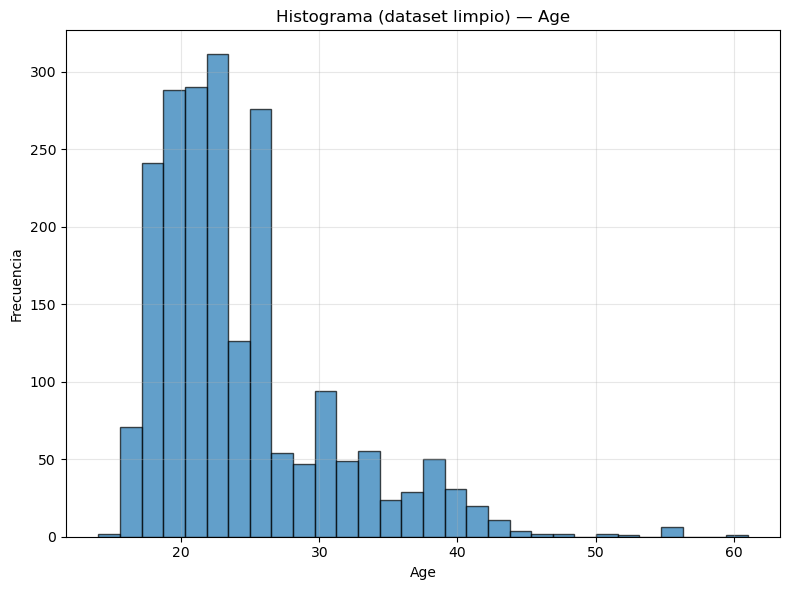

In [14]:
# ========================================
# VISUALIZACIÓN 1: HISTOGRAMA DE VARIABLE NUMÉRICA
# ========================================

# Histograma de una columna numérica representativa (dataset limpio)
num_cols_clean = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols_clean:
    col_num = num_cols_clean[0]
    plt.figure(figsize=(8, 6))
    plt.hist(df[col_num].dropna().astype(float), bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel(col_num)
    plt.ylabel("Frecuencia")
    plt.title(f"Histograma (dataset limpio) — {col_num}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron columnas numéricas para visualizar")


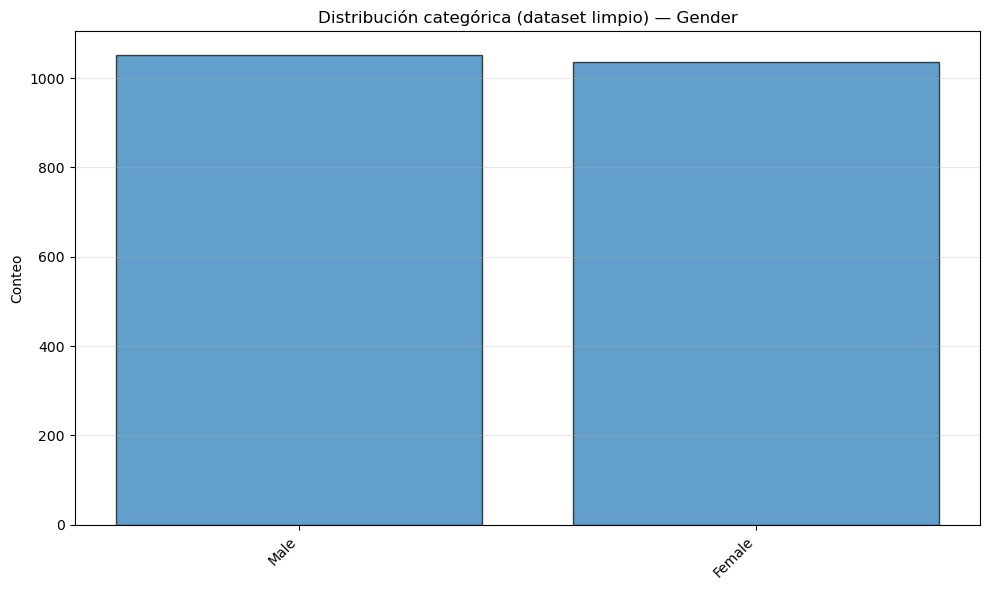

In [15]:
# ========================================
# VISUALIZACIÓN 2: DISTRIBUCIÓN DE VARIABLE CATEGÓRICA
# ========================================

# Barras de una columna categórica representativa (dataset limpio)
cat_cols_clean = [c for c in df.columns if c not in num_cols_clean]
if cat_cols_clean:
    col_cat = cat_cols_clean[0]
    vc = df[col_cat].astype(str).value_counts().head(12)
    plt.figure(figsize=(10, 6))
    plt.bar(vc.index.astype(str), vc.values, alpha=0.7, edgecolor='black')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Conteo")
    plt.title(f"Distribución categórica (dataset limpio) — {col_cat}")
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron columnas categóricas para visualizar")


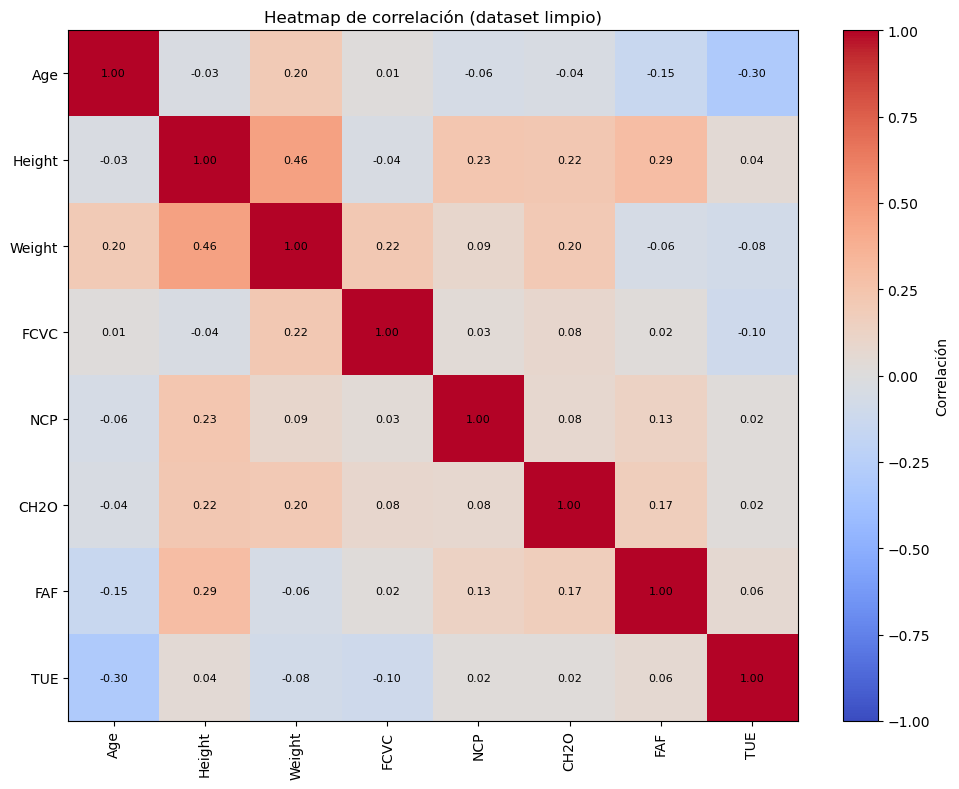

In [16]:
# ========================================
# VISUALIZACIÓN 3: HEATMAP DE CORRELACIONES
# ========================================

# Heatmap de correlaciones numéricas (dataset limpio), si hay suficientes columnas
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols_all) >= 2:
    corr = df[num_cols_all].corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, aspect="auto", cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='Correlación')
    plt.xticks(range(len(num_cols_all)), num_cols_all, rotation=90)
    plt.yticks(range(len(num_cols_all)), num_cols_all)
    plt.title("Heatmap de correlación (dataset limpio)")
    
    # Agregar valores de correlación en cada celda
    for i in range(len(num_cols_all)):
        for j in range(len(num_cols_all)):
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', 
                    ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Solo se encontraron {len(num_cols_all)} columnas numéricas. Se necesitan al menos 2 para el heatmap.")


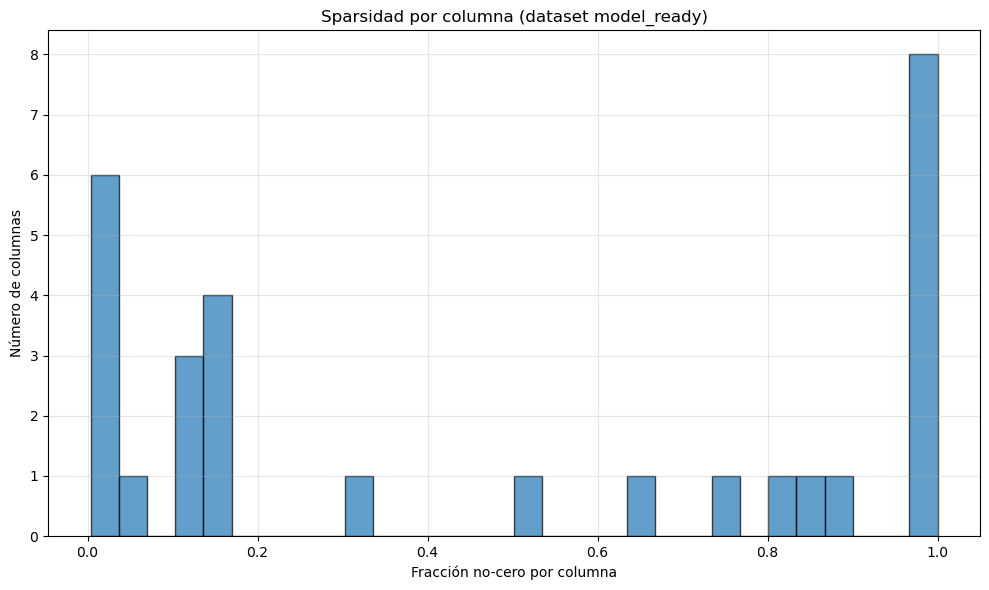

Estadísticas de sparsidad:
- Promedio de fracción no-cero: 0.480
- Mínimo: 0.003
- Máximo: 1.000


In [17]:
# ========================================
# VISUALIZACIÓN 4: SPARSIDAD DEL DATASET MODEL_READY
# ========================================

# Sparsidad por columna (dataset model_ready)
non_zero_frac = (df_model != 0).sum(axis=0) / max(1, len(df_model))
plt.figure(figsize=(10, 6))
plt.hist(non_zero_frac.values, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel("Fracción no-cero por columna")
plt.ylabel("Número de columnas")
plt.title("Sparsidad por columna (dataset model_ready)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Estadísticas de sparsidad:")
print(f"- Promedio de fracción no-cero: {non_zero_frac.mean():.3f}")
print(f"- Mínimo: {non_zero_frac.min():.3f}")
print(f"- Máximo: {non_zero_frac.max():.3f}")


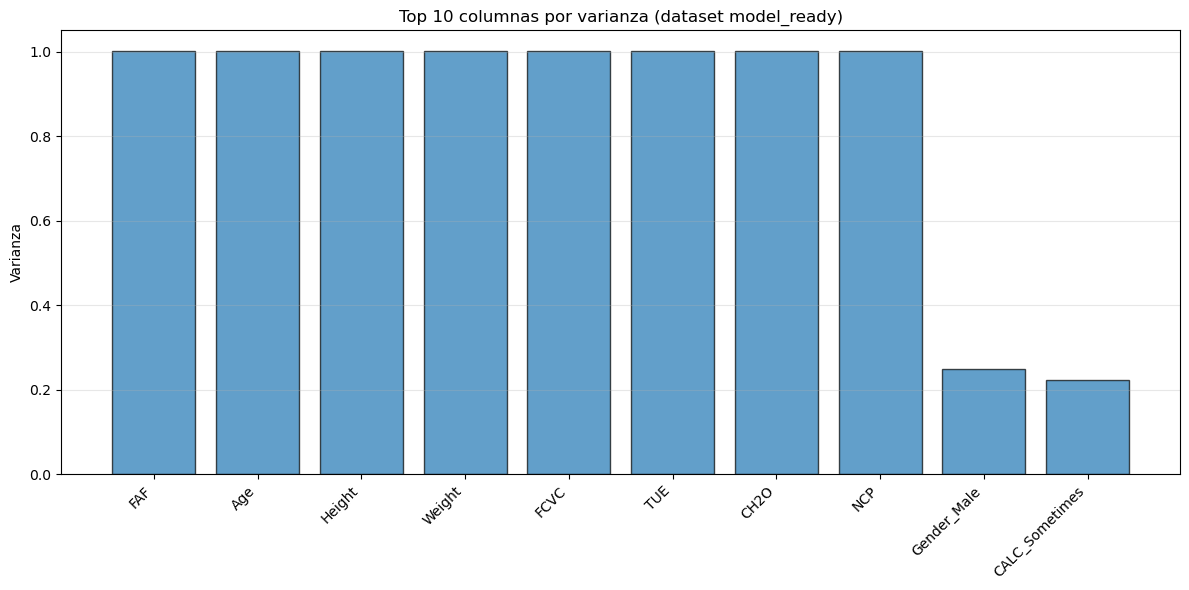

Top 10 columnas por varianza:
 1. FAF: 1.0005
 2. Age: 1.0005
 3. Height: 1.0005
 4. Weight: 1.0005
 5. FCVC: 1.0005
 6. TUE: 1.0005
 7. CH2O: 1.0005
 8. NCP: 1.0005
 9. Gender_Male: 0.2501
10. CALC_Sometimes: 0.2241


In [18]:
# ========================================
# VISUALIZACIÓN 5: TOP 10 COLUMNAS POR VARIANZA
# ========================================

# Top 10 columnas por varianza (dataset model_ready)
variances = df_model.var(numeric_only=True).sort_values(ascending=False).head(10)
if len(variances) > 0:
    plt.figure(figsize=(12, 6))
    plt.bar(variances.index.astype(str), variances.values, alpha=0.7, edgecolor='black')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Varianza")
    plt.title("Top 10 columnas por varianza (dataset model_ready)")
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 columnas por varianza:")
    for i, (col, var) in enumerate(variances.items(), 1):
        print(f"{i:2d}. {col}: {var:.4f}")
else:
    print("No se encontraron columnas numéricas para calcular varianza")


In [19]:
# ========================================
# RESUMEN DE PROCESAMIENTO COMPLETADO
# ========================================

print("=" * 60)
print("RESUMEN DEL PROCESAMIENTO DE DATOS")
print("=" * 60)

print(f"\n📊 DATASET ORIGINAL:")
print(f"   - Filas: {df_raw.shape[0]}")
print(f"   - Columnas: {df_raw.shape[1]}")

print(f"\n🧹 DATASET LIMPIO:")
print(f"   - Filas: {df.shape[0]}")
print(f"   - Columnas: {df.shape[1]}")
print(f"   - Guardado en: {clean_path}")

print(f"\n🤖 DATASET PARA MODELADO:")
print(f"   - Filas: {df_model.shape[0]}")
print(f"   - Columnas: {df_model.shape[1]}")
print(f"   - Guardado en: {model_path}")

print(f"\n📈 VISUALIZACIONES GENERADAS:")
print(f"   1. Histograma de variable numérica")
print(f"   2. Distribución de variable categórica")
print(f"   3. Heatmap de correlaciones")
print(f"   4. Análisis de sparsidad")
print(f"   5. Top 10 columnas por varianza")

print(f"\n✅ PROCESAMIENTO COMPLETADO EXITOSAMENTE")
print("=" * 60)

RESUMEN DEL PROCESAMIENTO DE DATOS

📊 DATASET ORIGINAL:
   - Filas: 2111
   - Columnas: 17

🧹 DATASET LIMPIO:
   - Filas: 2087
   - Columnas: 17
   - Guardado en: ../data/interim/obesity_clean_raw.csv

🤖 DATASET PARA MODELADO:
   - Filas: 2087
   - Columnas: 29
   - Guardado en: ../data/processed/obesity_model_ready.csv

📈 VISUALIZACIONES GENERADAS:
   1. Histograma de variable numérica
   2. Distribución de variable categórica
   3. Heatmap de correlaciones
   4. Análisis de sparsidad
   5. Top 10 columnas por varianza

✅ PROCESAMIENTO COMPLETADO EXITOSAMENTE
